In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pathlib import Path
import numpy as np
import tensorflow as tf
import random, shutil
from tensorflow.keras.preprocessing import image_dataset_from_directory
from collections import Counter
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [ ]:

zip_path = '/content/drive/MyDrive/PCOS.zip'
extract_path = '/content/pcos_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
base_path = os.path.join(extract_path, 'PCOS')

for folder in ['infected', 'noninfected']:
    folder_path = os.path.join(base_path, folder)
    images = [f for f in os.listdir(folder_path)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"{folder}: {len(images)} images")


infected: 6784 images
noninfected: 5000 images



Showing 10 random images from infected:


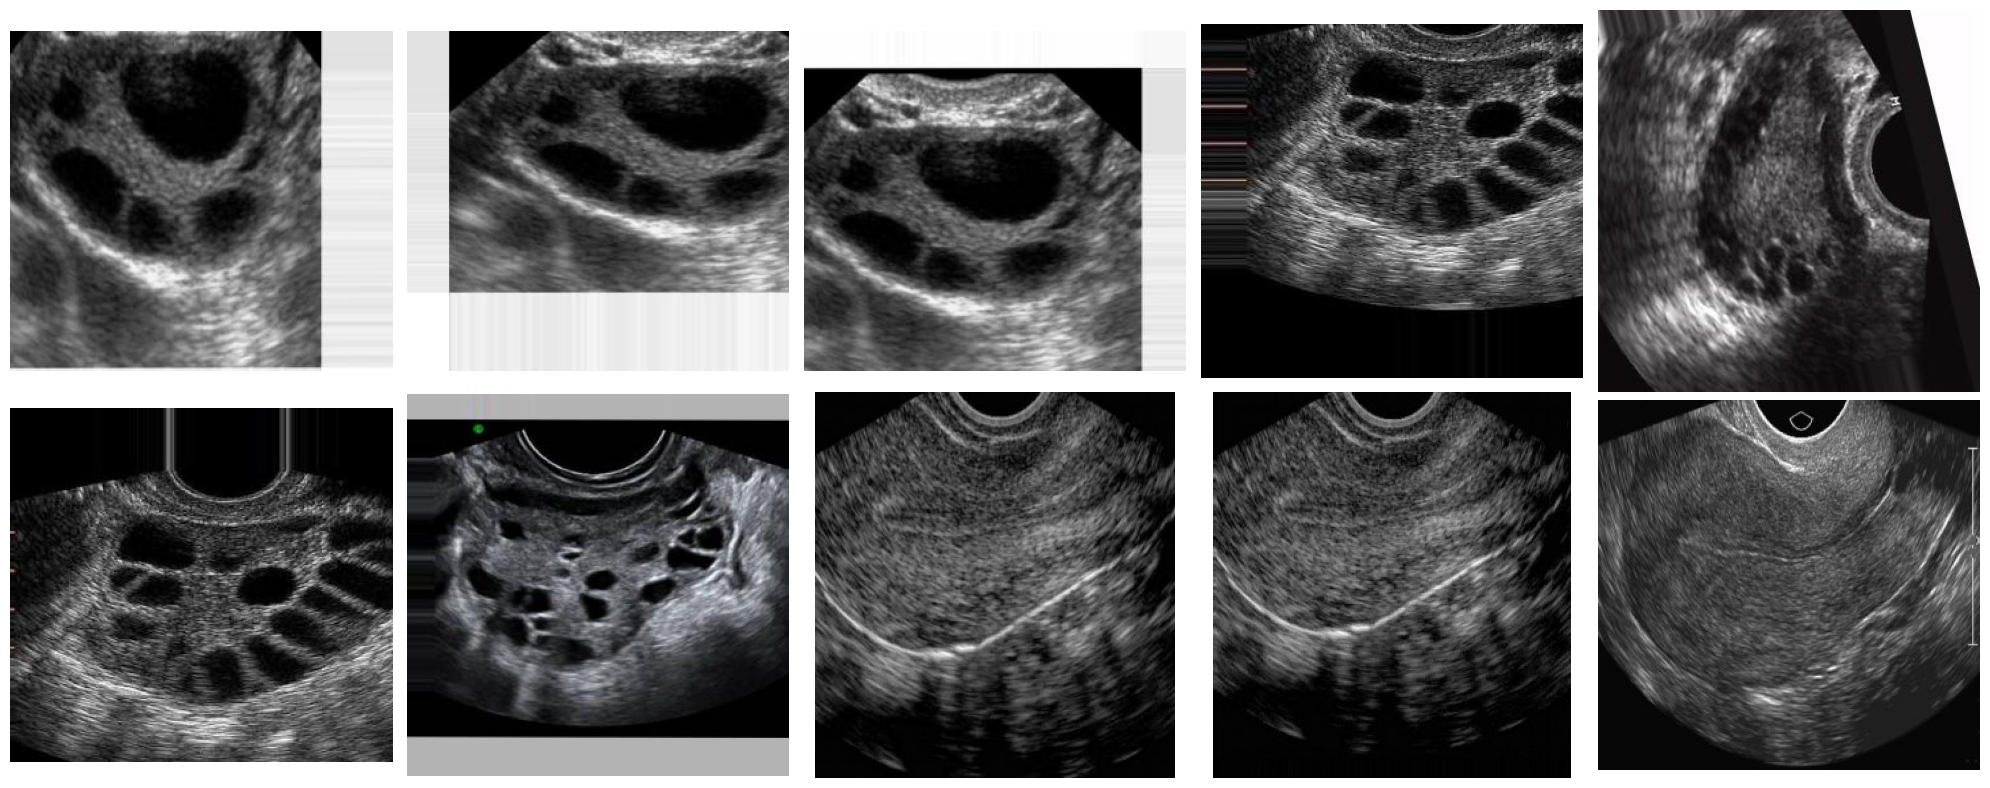


Showing 10 random images from noninfected:


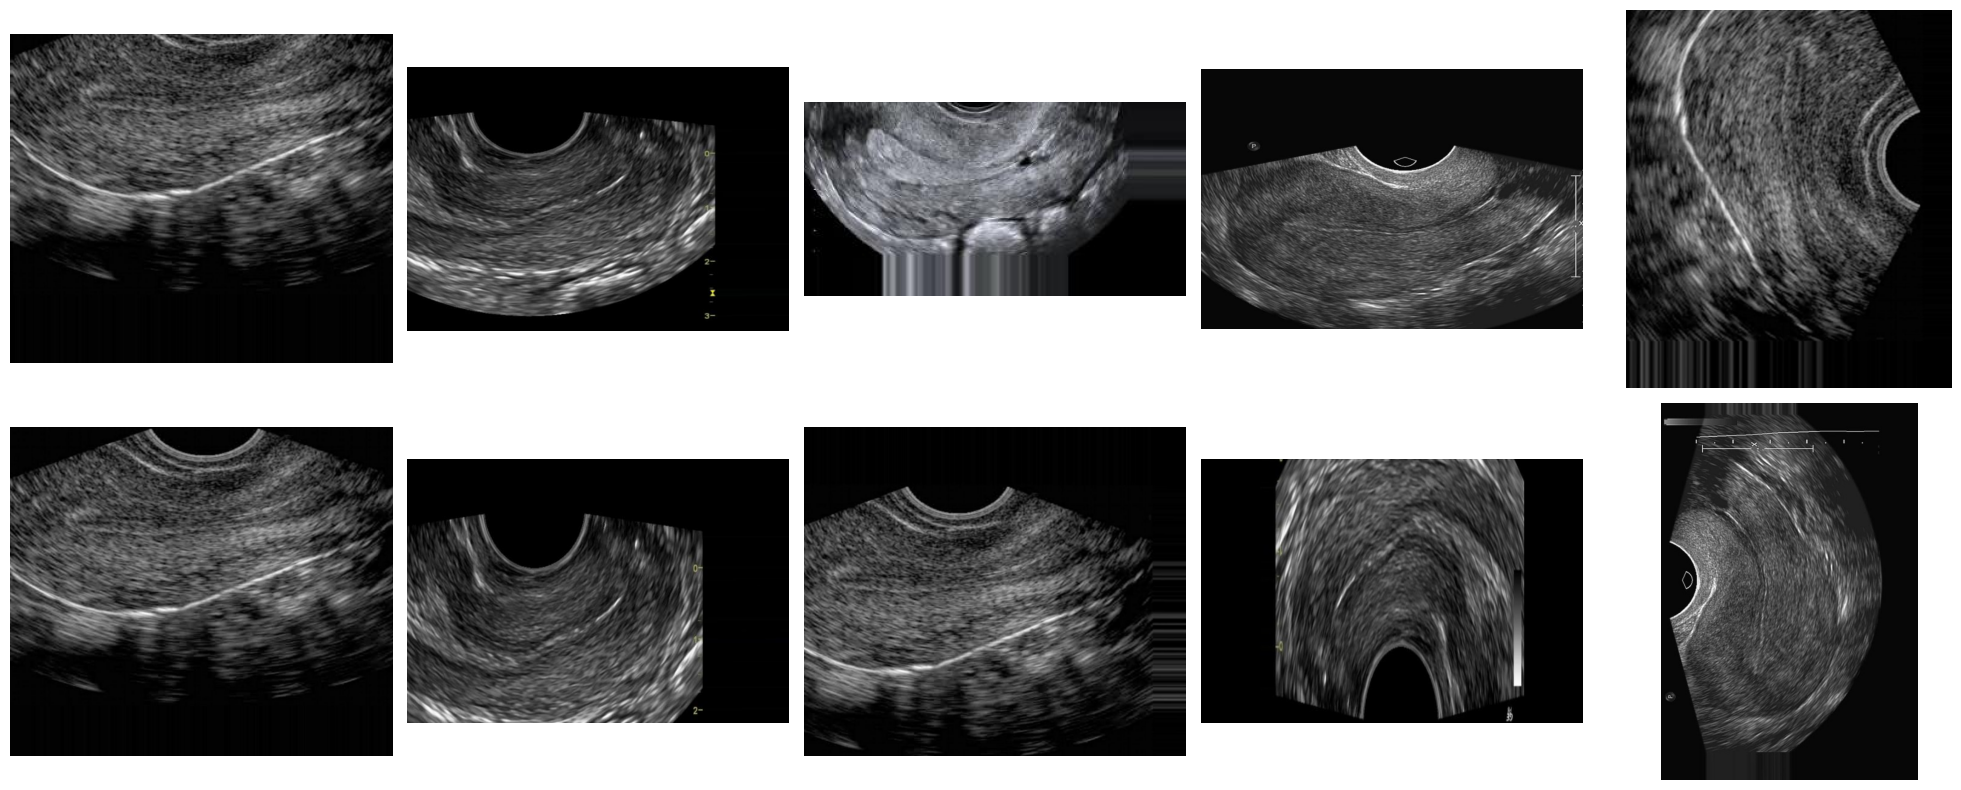

In [ ]:
for folder in ['infected', 'noninfected']:
    folder_path = os.path.join(base_path, folder)
    images = [f for f in os.listdir(folder_path)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # pick 10 random images (or all if folder has fewer)
    sample_images = random.sample(images, min(10, len(images)))

    print(f"\nShowing 10 random images from {folder}:")
    plt.figure(figsize=(20, 8))  # larger figure for 10 images

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(2, 5, i+1)  # 2 rows x 5 columns grid
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:

# Enable mixed precision for speed (only if GPU supports it)
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled:", tf.keras.mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision not enabled:", e)

# Paths - change if needed
BASE = Path('/content/pcos_data/PCOS')   # your extracted folder containing 'infected' and 'noninfected'
assert BASE.exists(), f"Path not found: {BASE}"

print("Base path:", BASE)


Mixed precision enabled: <DTypePolicy "mixed_float16">
Base path: /content/pcos_data/PCOS


It uses fast 16-bit math for most calculations but keeps critical parts in precise 32-bit to maintain accuracy. This gives you:
2-3x faster training ,
Larger batch sizes,
Same great accuracy

In [ ]:
# Colab cell 2 - deterministic split


SPLIT_ROOT = Path('/content/pcos_split')
SPLIT_ROOT.mkdir(parents=True, exist_ok=True)

def make_split_for_class(src_dir, out_root, splits=(0.8,0.1,0.1), seed=42): #seed =42 means same shuffle everytime u run it
    files = [p for p in Path(src_dir).glob('*') if p.suffix.lower() in ('.jpg','.jpeg','.png','.bmp')]
    random.Random(seed).shuffle(files)
    n = len(files)
    n_train = int(splits[0]*n)
    n_val = int(splits[1]*n)
    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]
    for split_name, file_list in [('train',train_files),('val',val_files),('test',test_files)]:
        d = Path(out_root)/split_name/Path(src_dir).name
        d.mkdir(parents=True, exist_ok=True)
        for f in file_list:
            shutil.copy(f, d / f.name)

for cls in ['infected','noninfected']:
    make_split_for_class(BASE/cls, SPLIT_ROOT)

# Print counts
for s in ['train','val','test']:
    for cls in ['infected','noninfected']:
        p = SPLIT_ROOT/s/cls
        print(s, cls, len(list(p.glob('*'))))




train infected 5427
train noninfected 4000
val infected 678
val noninfected 500
test infected 679
test noninfected 500


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
IMG_SIZE = (224, 224)
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE # automatically finds out optimal setting like how mnany images to process at onnce based on cpu cap, mem available
SEED = 42

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    SPLIT_ROOT / 'train',
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    SPLIT_ROOT / 'val',
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    SPLIT_ROOT / 'test',
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)


# Data augmentation (train only)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])

# Prepare datasets
def prepare(ds, augment=False, shuffle=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (preprocess_input(tf.cast(x, tf.float32)), y),
                num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(500, seed=SEED)
    ds = ds.prefetch(1)  # keep only 1 batch in RAM
    return ds

train_ds = prepare(train_ds, augment=True, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)


Found 9427 files belonging to 2 classes.
Found 1178 files belonging to 2 classes.
Found 1179 files belonging to 2 classes.


In [ ]:
# Colab cell 4 - compute class weights

train_counts = {}
train_base = SPLIT_ROOT/'train'
train_counts['infected'] = len(list((train_base/'infected').glob('*')))
train_counts['noninfected'] = len(list((train_base/'noninfected').glob('*')))
print("Train counts:", train_counts)

# Map class indices: image_dataset_from_directory sorts class names alphabetically.
# Print class order to be safe:
print("class names order (image_dataset_from_directory):", image_dataset_from_directory(SPLIT_ROOT/'train', image_size=IMG_SIZE, batch_size=1).class_names)

# Build y_train list to compute balanced class weights (if small)
y_train = []
for batch in image_dataset_from_directory(SPLIT_ROOT/'train', image_size=IMG_SIZE, batch_size=1, shuffle=False):
    _, labels = batch
    for l in labels.numpy().tolist():
        y_train.append(int(l))
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)


Train counts: {'infected': 5427, 'noninfected': 4000}
Found 9427 files belonging to 2 classes.
class names order (image_dataset_from_directory): ['infected', 'noninfected']
Found 9427 files belonging to 2 classes.
Class weights: {0: 0.8685277317118113, 1: 1.178375}


 EfficientNet-B4 (pre-trained feature extractor)

Custom classification head (trained specifically for PCOS detection)

In [ ]:
# Colab cell 5 - build model
def build_efficientnetb4_head(img_size=IMG_SIZE, dropout_rate=0.5, l2=1e-4):
    base = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(*img_size,3), pooling='avg')
    base.trainable = False  # freeze base

    inp = layers.Input(shape=(*img_size,3), dtype=tf.float32)
    x = base(inp, training=False)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate*0.6)(x)
    x = layers.Dense(1)(x)
    out = layers.Activation('sigmoid', dtype='float32')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

model = build_efficientnetb4_head()
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1792)           │         7,168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,667,360 (71.21 MB)

 Trainable params: 988,673 (3.77 MB)

 Non-trainable params: 17,678,687 (67.44 MB)

In [ ]:
# Colab cell 6 - compile and callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

LR_HEAD = 1e-4
model.compile(
    optimizer=Adam(learning_rate=LR_HEAD),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Save model to Drive
MODEL_DIR = Path('/content/drive/MyDrive/pcos_models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
checkpoint_path = str(MODEL_DIR/'efficientnetb4_pcos_best.h5')

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True, verbose=1)
]

# Optional: batch-level tqdm bar
!pip install keras-tqdm
from keras_tqdm import TQDMCallback

# ======================
# Colab Cell 5 - Train Head
# ======================
EPOCHS_HEAD = 10

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
    verbose=1  # default Keras epoch-level progress bar
)



Epoch 1/10
2357/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7612 - auc: 0.8377 - loss: 0.6145
Epoch 1: val_auc improved from -inf to 0.98028, saving model to /content/drive/MyDrive/pcos_models/efficientnetb4_pcos_best.h5


2357/2357 ━━━━━━━━━━━━━━━━━━━━ 329s 99ms/step - accuracy: 0.7612 - auc: 0.8377 - loss: 0.6144 - val_accuracy: 0.8879 - val_auc: 0.9803 - val_loss: 0.3787 - learning_rate: 1.0000e-04
Epoch 2/10
2356/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8499 - auc: 0.9235 - loss: 0.4590
Epoch 2: val_auc improved from 0.98028 to 0.98547, saving model to /content/drive/MyDrive/pcos_models/efficientnetb4_pcos_best.h5


2357/2357 ━━━━━━━━━━━━━━━━━━━━ 154s 55ms/step - accuracy: 0.8499 - auc: 0.9235 - loss: 0.4590 - val_accuracy: 0.9278 - val_auc: 0.9855 - val_loss: 0.2745 - learning_rate: 1.0000e-04
Epoch 3/10
2355/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8650 - auc: 0.9393 - loss: 0.4182
Epoch 3: val_auc improved from 0.98547 to 0.98654, saving model to /content/drive/MyDrive/pcos_models/efficientnetb4_pcos_best.h5


2357/2357 ━━━━━━━━━━━━━━━━━━━━ 153s 54ms/step - accuracy: 0.8650 - auc: 0.9393 - loss: 0.4182 - val_accuracy: 0.9372 - val_auc: 0.9865 - val_loss: 0.2693 - learning_rate: 1.0000e-04
Epoch 4/10
2354/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8770 - auc: 0.9476 - loss: 0.3961
Epoch 4: val_auc improved from 0.98654 to 0.98931, saving model to /content/drive/MyDrive/pcos_models/efficientnetb4_pcos_best.h5


2357/2357 ━━━━━━━━━━━━━━━━━━━━ 158s 57ms/step - accuracy: 0.8770 - auc: 0.9476 - loss: 0.3961 - val_accuracy: 0.9346 - val_auc: 0.9893 - val_loss: 0.2717 - learning_rate: 1.0000e-04
Epoch 5/10
2355/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8755 - auc: 0.9445 - loss: 0.4009
Epoch 5: val_auc improved from 0.98931 to 0.98983, saving model to /content/drive/MyDrive/pcos_models/efficientnetb4_pcos_best.h5


2357/2357 ━━━━━━━━━━━━━━━━━━━━ 153s 54ms/step - accuracy: 0.8755 - auc: 0.9445 - loss: 0.4009 - val_accuracy: 0.9448 - val_auc: 0.9898 - val_loss: 0.2532 - learning_rate: 1.0000e-04
Epoch 6/10
2353/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8818 - auc: 0.9506 - loss: 0.3869
Epoch 6: val_auc improved from 0.98983 to 0.99167, saving model to /content/drive/MyDrive/pcos_models/efficientnetb4_pcos_best.h5


2357/2357 ━━━━━━━━━━━━━━━━━━━━ 150s 53ms/step - accuracy: 0.8818 - auc: 0.9506 - loss: 0.3869 - val_accuracy: 0.9397 - val_auc: 0.9917 - val_loss: 0.2566 - learning_rate: 1.0000e-04
Epoch 7/10
2356/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8858 - auc: 0.9510 - loss: 0.3850
Epoch 7: val_auc did not improve from 0.99167
2357/2357 ━━━━━━━━━━━━━━━━━━━━ 150s 53ms/step - accuracy: 0.8858 - auc: 0.9510 - loss: 0.3850 - val_accuracy: 0.9363 - val_auc: 0.9915 - val_loss: 0.2625 - learning_rate: 1.0000e-04
Epoch 8/10
2357/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8851 - auc: 0.9544 - loss: 0.3760
Epoch 8: val_auc improved from 0.99167 to 0.99235, saving model to /content/drive/MyDrive/pcos_models/efficientnetb4_pcos_best.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2357/2357 ━━━━━━━━━━━━━━━━━━━━ 151s 54ms/step - accuracy: 0.8851 - auc: 0.9544 - loss: 0.3760 - val_accuracy: 0.9329 - val_auc: 0.9924 - val_loss: 0.2600 - learning_rate: 1.0000e-04
Epoch 9/10
2356/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8951 - auc: 0.9623 - loss: 0.3534
Epoch 9: val_auc improved from 0.99235 to 0.99251, saving model to /content/drive/MyDrive/pcos_models/efficientnetb4_pcos_best.h5


2357/2357 ━━━━━━━━━━━━━━━━━━━━ 152s 54ms/step - accuracy: 0.8951 - auc: 0.9623 - loss: 0.3534 - val_accuracy: 0.9482 - val_auc: 0.9925 - val_loss: 0.2418 - learning_rate: 5.0000e-05
Epoch 10/10
2354/2357 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8963 - auc: 0.9581 - loss: 0.3637
Epoch 10: val_auc did not improve from 0.99251
2357/2357 ━━━━━━━━━━━━━━━━━━━━ 148s 52ms/step - accuracy: 0.8963 - auc: 0.9581 - loss: 0.3637 - val_accuracy: 0.9474 - val_auc: 0.9922 - val_loss: 0.2389 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 9.


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


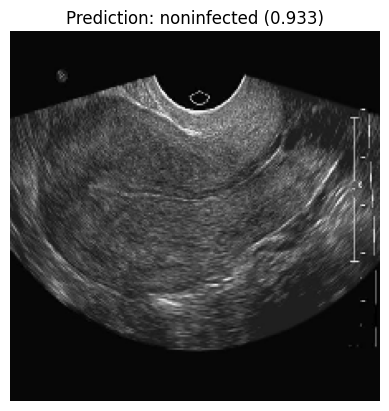

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
#  Load saved model
MODEL_PATH = '/content/drive/MyDrive/pcos_models/efficientnetb4_pcos_best.h5'
model = load_model(MODEL_PATH)
print("Model loaded successfully!")

#  Path to your test image (change to your image path)
img_path = '/content/pcos_data/PCOS/noninfected/Image_002.jpg'  # example path

#  Load & preprocess image
IMG_SIZE = (224, 224)  # same size used in training
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # make batch of 1
img_array = preprocess_input(img_array)         # EfficientNet preprocessing

#  Predict
pred = model.predict(img_array)[0][0]  # sigmoid output
pred_label = 'noninfected' if pred > 0.5 else 'infected'

#  Show results
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {pred_label} ({pred:.3f})')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━

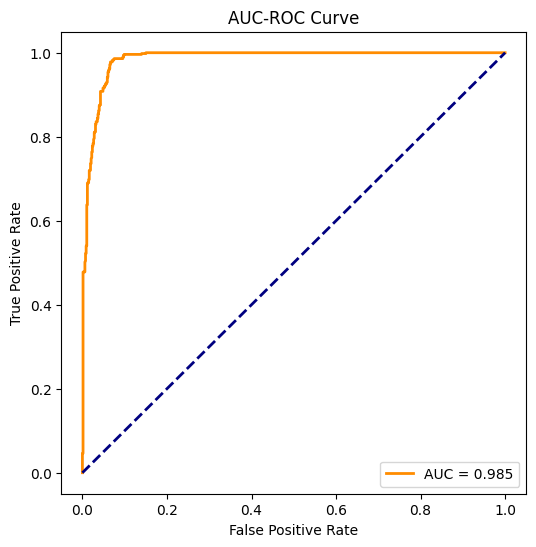

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get true and predicted labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.concatenate([model.predict(x) for x, y in test_ds], axis=0)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.show()


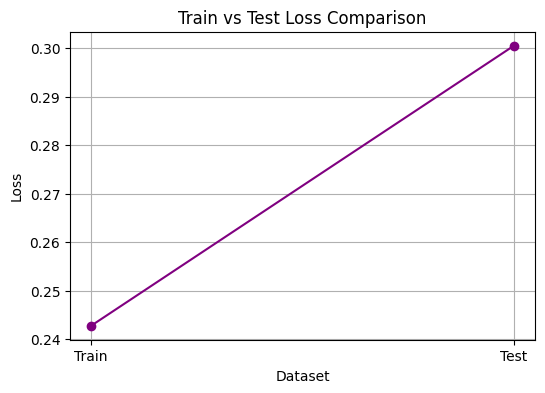

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(['Train', 'Test'], [train_loss, test_loss], marker='o', linestyle='-', color='purple')
plt.title('Train vs Test Loss Comparison')
plt.xlabel('Dataset')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


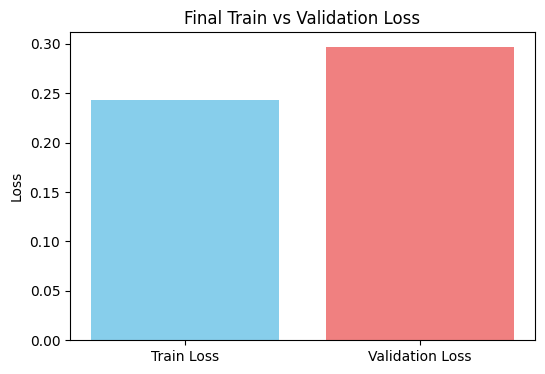

In [ ]:

train_loss = 0.2427
val_loss = 0.2968

plt.figure(figsize=(6,4))
plt.bar(['Train Loss', 'Validation Loss'], [train_loss, val_loss], color=['skyblue', 'lightcoral'])
plt.title('Final Train vs Validation Loss')
plt.ylabel('Loss')
plt.show()


EXPLAINABLE AI -occlussion
You systematically hide (occlude) small regions of the input image usually by covering them with a black patch and then observe how the model’s output changes.
If masking a patch reduces confidence → that patch was important for the decision.
If masking a patch does nothing → that patch didn’t matter.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: infected (0.020)


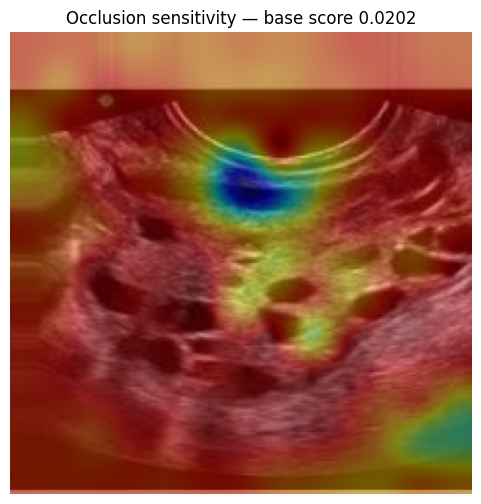

In [ ]:
# Occlusion sensitivity (sliding-window) heatmap — gradient-free and robust
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2
import math
import tqdm  # progress bar (Colab has it)

# ---- USER: set image path and parameters ----
img_path = '/content/pcos_data/PCOS/infected/Image_179.jpg'   # change as needed
IMG_SIZE = (224, 224)      # must match training
patch = 32                 # occlusion patch size (try 32 or 48)
stride = 16                # sliding step
batch_size = 64            # batch size when calling model.predict (speed)
mask_value = 0             # value to fill occluded patch (0-black); try 127 or 255 for alternate)
target_class = 1           # use 1 if you want to measure effect on PCOS neuron; we'll use predicted neuron

# ---- preprocess image ----
pil_img = image.load_img(img_path, target_size=IMG_SIZE)
img_arr = image.img_to_array(pil_img).astype(np.float32)
img_batch = np.expand_dims(img_arr, axis=0)
img_pre = tf.keras.applications.efficientnet.preprocess_input(img_batch)

# ---- base prediction (probability) ----
base_pred = model.predict(img_pre)[0][0]   # scalar probability (same as your earlier usage)
pred_label = 'noninfected' if base_pred > 0.706 else 'infected'
print(f"Prediction: {pred_label} ({base_pred:.3f})")


H, W = IMG_SIZE
# compute grid positions
ys = list(range(0, H - patch + 1, stride))
xs = list(range(0, W - patch + 1, stride))
if (H - patch) % stride != 0: ys.append(H - patch)
if (W - patch) % stride != 0: xs.append(W - patch)

positions = [(y, x) for y in ys for x in xs]
heatmap = np.zeros((len(ys), len(xs)), dtype=np.float32)

# build occluded batches and predict
batches = []
pos_idx = []
for i, (y, x) in enumerate(positions):
    img_copy = img_arr.copy()
    img_copy[y:y+patch, x:x+patch, :] = mask_value
    batches.append(img_copy)
    pos_idx.append((y, x))
    # predict in batches
    if len(batches) == batch_size or i == len(positions)-1:
        batch_np = np.array(batches)
        batch_pre = tf.keras.applications.efficientnet.preprocess_input(batch_np)
        preds = model.predict(batch_pre, verbose=0)  # shape (B,1)
        # we measure drop in predicted probability for the original predicted neuron (use 0 index)
        # if you'd like to focus on the "PCOS" neuron set target_class accordingly
        preds = preds.reshape(-1)
        for j, p in enumerate(preds):
            yy, xx = pos_idx[j]
            iy = ys.index(yy)
            ix = xs.index(xx)
            # importance = base_pred - p  (how much occluding lowered the score)
            # if prediction goes up when occluding, importance will be negative; clamp to 0
            importance = base_pred - float(p)
            heatmap[iy, ix] = importance
        batches = []
        pos_idx = []

# Resize heatmap to image size (interpolate)
heatmap_resized = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_CUBIC)
# normalize to 0-1
if np.max(heatmap_resized) > 0:
    heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())
else:
    heatmap_resized = np.zeros_like(heatmap_resized)

# Display overlay (fixed)
plt.figure(figsize=(6,6))
plt.imshow(np.array(pil_img).astype('uint8'))  # Convert Pillow image → NumPy before plotting
plt.imshow(heatmap_resized, cmap='jet', alpha=0.45)
plt.axis('off')
plt.title(f"Occlusion sensitivity — base score {base_pred:.4f}")
plt.show()


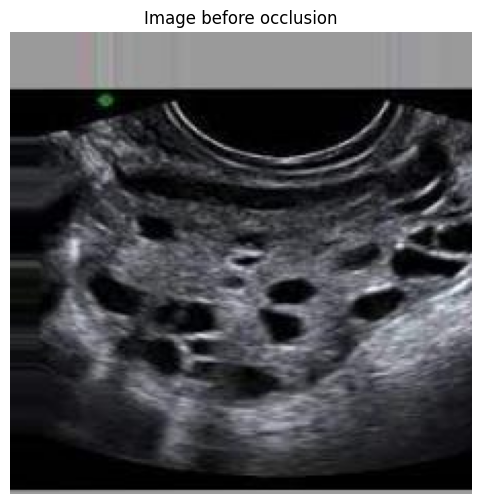

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = '/content/pcos_data/PCOS/infected/Image_179.jpg'

plt.figure(figsize=(6,6))
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title('Image before occlusion')
plt.show()

red means that full part is taken for evaluation, green or yelllow means those parts are influencing the decision, blue means the part whicch doesnt matter for decision making


In [ ]:
from sklearn.metrics import roc_curve

y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = model.predict(test_ds)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
# Find the threshold that maximizes sensitivity + specificity
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:", optimal_threshold)


295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Optimal threshold: 0.70608914


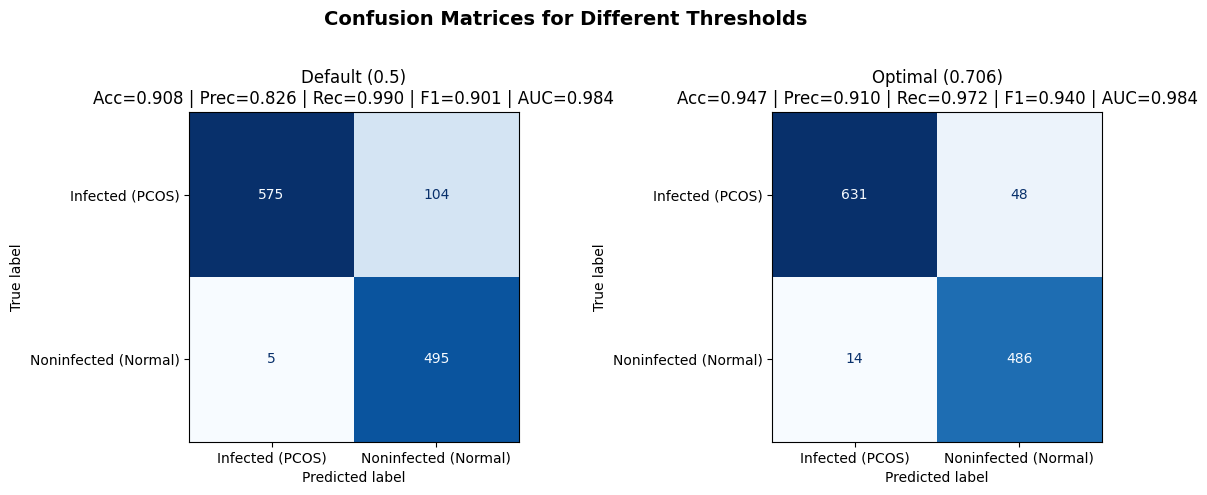


=== Default (0.5) Threshold (0.5) ===
Confusion Matrix:
[[575 104]
 [  5 495]]
Accuracy : 0.9075
Precision: 0.8264
Recall   : 0.9900
F1-score : 0.9008
AUC-ROC  : 0.9841

=== Optimal (0.706) Threshold (0.706) ===
Confusion Matrix:
[[631  48]
 [ 14 486]]
Accuracy : 0.9474
Precision: 0.9101
Recall   : 0.9720
F1-score : 0.9400
AUC-ROC  : 0.9841


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- Define thresholds ---
thresholds = [0.5, 0.706]
threshold_names = ['Default (0.5)', 'Optimal (0.706)']

# --- Create figure for confusion matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Confusion Matrices for Different Thresholds', fontsize=14, fontweight='bold')

# --- Loop through thresholds ---
for i, th in enumerate(thresholds):
    # Convert probabilities to class labels
    y_pred_labels = (y_pred > th).astype(int)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred_labels)
    prec = precision_score(y_true, y_pred_labels)
    rec = recall_score(y_true, y_pred_labels)
    f1 = f1_score(y_true, y_pred_labels)
    auc = roc_auc_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Infected (PCOS)', 'Noninfected (Normal)'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"{threshold_names[i]}\nAcc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1={f1:.3f} | AUC={auc:.3f}")
    axes[i].grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Print detailed results ---
for th, name in zip(thresholds, threshold_names):
    y_pred_labels = (y_pred > th).astype(int)
    acc = accuracy_score(y_true, y_pred_labels)
    prec = precision_score(y_true, y_pred_labels)
    rec = recall_score(y_true, y_pred_labels)
    f1 = f1_score(y_true, y_pred_labels)
    auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred_labels)
    print(f"\n=== {name} Threshold ({th}) ===")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUC-ROC  : {auc:.4f}")


RESNET50

Found 9427 images belonging to 2 classes.
Found 1178 images belonging to 2 classes.
Found 1179 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 152s 465ms/step - accuracy: 0.5805 - loss: 0.7023 - val_accuracy: 0.7334 - val_loss: 0.5131
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 123s 416ms/step - accuracy: 0.7382 - loss: 0.5225 - val_accuracy: 0.7954 - val_loss: 0.4441
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 119s 404ms/step - accuracy: 0.7851 - loss: 0.4632 - val_accuracy: 0.7716 - val_loss: 0.4219
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 122s 415ms/step - accuracy: 0.7990 - loss: 0.4318 - val_accuracy: 0.7801 - val_loss: 0.4061
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 140s 408ms/step - accuracy: 0.8028 - loss: 0.4168 - val_accuracy: 0.8166 - val_loss: 0.3753
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 122s 414ms/step - accuracy: 0.8134 - loss: 0.4032 - val_accuracy: 0.7963 - val_loss: 0.3757
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 123s 417ms/step - accuracy: 0.8135 - loss: 0.3914 - val_accuracy: 0.8243 - val_loss: 0.3516
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 120s 405ms/step - accuracy: 0.8172 -

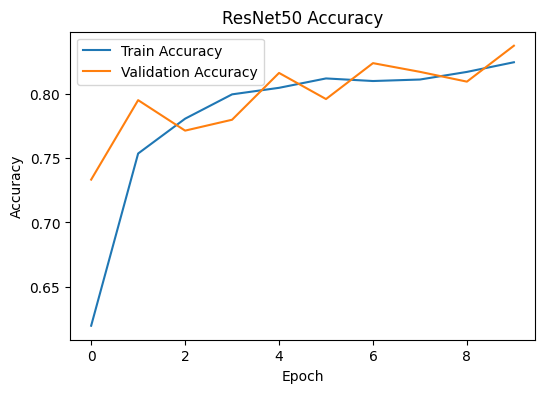

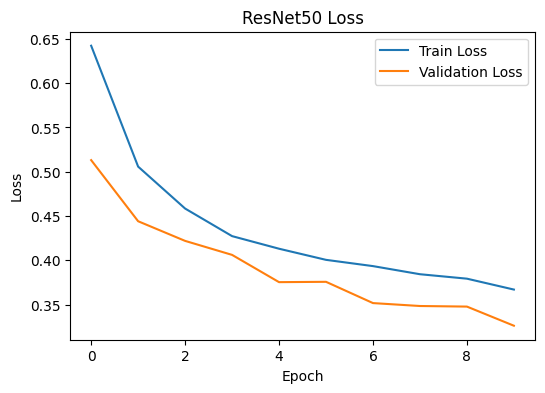

 Model saved as resnet50_model.h5


In [ ]:

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


train_dir = '/content/pcos_split/train'
val_dir = '/content/pcos_split/val'
test_dir = '/content/pcos_split/test'

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')
val_ds = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')
test_ds = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False)

#  Step 3: Load base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base layers (to use pretrained features)
for layer in base_model.layers:
    layer.trainable = False

#  Step 4: Add custom classifier on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model_resnet = Model(inputs=base_model.input, outputs=output)

#  Step 5: Compile model
model_resnet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

#  Step 6: Train model
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,   # you can increase this (e.g., 20)
    verbose=1
)

#  Step 7: Evaluate on test set
y_pred_prob = model_resnet.predict(test_ds)
y_true = test_ds.classes
threshold = 0.706
y_pred = (y_pred_prob > threshold).astype(int)

#  Step 8: Print metrics
acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)

print(f"\nResNet50 Model Evaluation:")
print(f"Accuracy at threshold {threshold}: {acc*100:.2f}%")
print(f"AUC: {auc:.3f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

#  Step 9: Plot training history
plt.figure(figsize=(6,4))
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#  Step 10: Save model
model_resnet.save('/content/resnet50_model.h5')
print(" Model saved as resnet50_model.h5")
